# <font color=slateblue>**Importing Neccessary Libraries**</font> #

In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)


from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [ ]:
!pip install silence_tensorflow

In [54]:
#General Libraries
import numpy as np
import pandas as pd
from math import isclose
from sklearn.externals.six.moves import xrange
import random

#Liberaries for Plotting
from tabulate import tabulate
import itertools   
import matplotlib.pyplot as plt

#Preprocessing Libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split as trainTestSplitter
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import FastICA
from imblearn.over_sampling import SMOTE

#Generative Aprroach Libraries
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture as GMM

#Discriminative Approach Libraries
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.neural_network import MLPClassifier
#Keras 
from keras.models import Model
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn import decomposition
from sklearn.neural_network import BernoulliRBM
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from keras.layers import Layer
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

#Bagging
from sklearn.ensemble import BaggingClassifier

#Metrics
from sklearn import metrics
from sklearn.model_selection import cross_val_score as crossValScore
from sklearn.metrics import accuracy_score as accScore
from sklearn.metrics import f1_score as f1Score
from sklearn.metrics import roc_curve as ROC 
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import plot_confusion_matrix as plotConfustionMatrix
from sklearn.model_selection import GridSearchCV


from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [50]:
myDataPath = '/content/gdrive/My Drive/Colab Notebooks/Final Project/pd_speech_features.csv'



## <font color=slateblue>Plot Table Beautifully :)</font> ##

In [6]:
def plotTable(clms, clmDataHeadears, alignSize):
    data = []
    
    for i in range(len(clms[list(clms.keys())[0]])):
        dataElement = []
        for key in clms.keys():
            dataElement.append(clms[key][i])
        data.append(dataElement)
        
    print(tabulate(data, headers=clmDataHeadears, tablefmt="fancy_grid", 
                   colalign=["center"]*alignSize))

# <font color=slateblue>**Preprocessing**</font> #

In [7]:
class Preprocessing():
  def __init__(self):
    pass

  def addFeatures(self, dataSetNew, dataSetOld, features):
    for feature in features:
      dataSetNew[feature] = dataSetOld[feature].values
    return dataSetNew 

  def normalizer(self, trainData, testData, featuresNotNorm, method='Standard Scaler'):
    newTrainData = trainData.drop(columns=featuresNotNorm)
    npTrainData = newTrainData.values

    newTestData = testData.drop(columns=featuresNotNorm)
    npTestData = newTestData.values

    preScaler = preprocessing.RobustScaler()
    preScaler.fit(npTrainData)
    npTrainData = preScaler.transform(npTrainData)
    npTestData = preScaler.transform(npTestData) 

    if method == 'Standard Scaler':
      meanStdScaler = preprocessing.StandardScaler()
      meanStdScaler.fit(npTrainData)

      npTrainData = meanStdScaler.transform(npTrainData)
      pdTrainData = pd.DataFrame(npTrainData, columns=newTrainData.columns)
      npTestData = meanStdScaler.transform(npTestData) 
      pdTestData = pd.DataFrame(npTestData, columns=newTestData.columns)
    
    elif method == 'Min Max Scaler':
      minMaxScaler = preprocessing.MinMaxScaler(feature_range = (0,1))
      minMaxScaler.fit(npTrainData)

      npTrainData = minMaxScaler.transform(npTrainData)
      pdTrainData = pd.DataFrame(npTrainData, columns=newTrainData.columns)
      npTestData = minMaxScaler.transform(npTestData) 
      pdTestData = pd.DataFrame(npTestData, columns=newTestData.columns)

    return self.addFeatures(pdTrainData, trainData, featuresNotNorm), self.addFeatures(pdTestData, testData, featuresNotNorm)

  def dataBalancer(self, data, dataLabels):
    oversample = SMOTE(random_state=42)
    data, dataLabels = oversample.fit_sample(data, dataLabels)
    unique, counts = np.unique(dataLabels, return_counts=True)
    print('After balancing data we got: ', dict(zip(unique, counts)))

    return data, dataLabels

  def PCA(self, trainData, testData, tolOpt=0.90, whitenState=False):
    myPCA = PCA(whiten=whitenState, random_state=42)
    dataPC = myPCA.fit_transform(trainData)

    #Find optimal PC
    cumSumComp = np.cumsum(myPCA.singular_values_/np.sum(myPCA.singular_values_))
    PCs = [i for i in range(0,len(cumSumComp)) 
           if isclose(cumSumComp[i], tolOpt, abs_tol=1e-1) 
           and isclose(cumSumComp[i], tolOpt, abs_tol=1e-2)]

    optPC = min(PCs)

    optPCA = PCA(n_components=optPC)
    trainDataPC = optPCA.fit_transform(trainData)
    testDataPC = optPCA.transform(testData)

    return trainDataPC, testDataPC

  def ICA(self, trainData, testData, numComp=None, whitenState=False, maxIter=200):
    myICA = FastICA(n_components=numComp, random_state=42, 
                    whiten=whitenState, max_iter=maxIter)
    
    trainDataICA = myICA.fit_transform(trainData)
    testDataICA = myICA.transform(testData)
    
    return trainDataICA, testDataICA

  def LDA(self, trainData, testData):
    lda = LDA()
    trainDataLDA = lda.fit_transform(trainData, trainLabels)
    testDataLDA = lda.transform(testData)
    return trainDataLDA, testDataLDA

  def AutoEncoder(self, trainData, testData, encDim=50):
    #Hyper Parameters
    encoding_dim = encDim
    autoEncoder_bachSize = 16

    #Construct AE Model
    my_input =layers.Input(shape=(753,))
    encoder = Dense(encoding_dim, activation='linear', use_bias = True)(my_input)
    decoder = Dense(753, activation='linear', use_bias = True)(encoder)
    autoEncoder = Model(my_input,decoder)
    autoEncoder.summary()

    #Train Model
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=False)
    autoEncoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    # import datetime
    # start=datetime.datetime.now()
    trained_model = autoEncoder.fit(trainData, trainData, batch_size= autoEncoder_bachSize, epochs=200, validation_split=0.2, shuffle=False, verbose=0)
    # end=datetime.datetime.now()
    # Total_time_training = end-start
    # print ('Total_time_training:',Total_time_training )

    myEncoder = Model(my_input, encoder)
    trainDataAE = myEncoder.predict(trainData)
    testDataAE = myEncoder.predict(testData)
    return trainDataAE, testDataAE

In [8]:
def readAndPreProsData(dataPath, 
                       dimReductionMethod, 
                       dimReductionInfo, 
                       normMethod='Standard Scaler',
                       splitState=True):

    data = pd.read_csv(dataPath)

    #Checking for NAN and missing data:
    missingDataHeader = [name for name in data.head() if (pd.isna(data[name])).any()]
    print('The number of missing data is:', len(missingDataHeader))

    #Removing ID feature:
    data.drop(columns=['id'], inplace=True)

    #Preprocessing
    myPrePros = Preprocessing()

    #Split train and test data sets:
    if splitState == True:
      trainData, testData, trainLabels, testLabels = trainTestSplitter(data.drop(columns=['class']), 
                                                                      data['class'], 
                                                                      test_size=0.2, 
                                                                      random_state=42)
    else:
      trainData, testData, trainLabels, testLabels =  data.drop(columns=['class']), data.drop(columns=['class']), data['class'], data['class']
      
    #Normalizing data sets:
    trainData, testData = myPrePros.normalizer(trainData, testData, 
                                              ['gender'], method=normMethod)
    #Balacing data sets:
    trainData, trainLabels = myPrePros.dataBalancer(trainData, trainLabels)

    #Dimension reduction methods:
    if dimReductionMethod == 'PCA':
      trainData, testData = myPrePros.PCA(trainData, testData, 
                                          tolOpt=dimReductionInfo['Tolerance Optimal Choice'], 
                                          whitenState=dimReductionInfo['Whitening State'])
    elif dimReductionMethod == 'LDA':
      trainData, testData = myPrePros.LDA(trainData, testData)

    elif dimReductionMethod == 'ICA':
      trainData, testData = myPrePros.ICA(trainData, testData, 
                                          numComp=dimReductionInfo['Number of Components'], 
                                          whitenState=dimReductionInfo['Whitening State'], 
                                          maxIter=dimReductionInfo['Max Iteration'])
    elif dimReductionMethod == 'AE':
      trainData, testData = myPrePros.AutoEncoder(trainData, testData, dimReductionInfo['Auto Encoder Dimension'])

    else :
      print('Undefined dimention reduction method, the available ones are: PCA, LDA, AE, and ICA')

    return  trainData, testData, trainLabels, testLabels


# <font color=slateblue>**Metrics**</font> #

In [9]:
class Metrics():
  def __init__(self, _clsf, trainData, trainLabels, testData, testLabels):
    self.clsf = _clsf
    self.trainData = trainData
    self.trainLabels = trainLabels
    self.testData = testData
    self.testLabels = testLabels

  def showParameters(self, param):
    keys = list(param.keys())
    clms = {1:['Hyperparameters']}
    clmHeaders = ['Parameters to Adjust']
    for i in range(0,len(keys)):
      if type(param[keys[i]]) == int or type(param[keys[i]]) == np.float64 or type(param[keys[i]]) == float:
        clms[i+2] = ['{:1.5f}'.format(param[keys[i]])] 
      else:
        clms[i+2] = [param[keys[i]]] 
      clmHeaders.append(keys[i])

    plotTable(clms, clmHeaders, len(keys)+1)

  def gridSearchCV(self, _cv, _grid):
    self.showParameters(_grid)

    myGS = GridSearchCV(self.clsf, _grid, cv=_cv)
    myGS.fit(self.trainData, self.trainLabels)

    self.showParameters(myGS.best_params_)
    
    return myGS.best_params_

  def giveData(self, dataSetType):
    if dataSetType == 'Train Data Set':
      data = self.trainData
      dataLabels = self.trainLabels
    elif dataSetType == 'Test Data Set':
      data = self.testData
      dataLabels = self.testLabels
    else:
      data = np.array([])
      dataLabels = np.array([])

    return data, dataLabels

  def plotConfMat(self, dispLabels, matrixTitle, dataSetType):
    data, dataLabels = self.giveData(dataSetType)

    if data.size == 0 or dataLabels.size == 0:
      print('Please enter a valid data set. You can try again with "Train Data Set" or "Test Data Set".')
      return 0

    disp = plotConfustionMatrix(self.clsf, data, dataLabels, display_labels=dispLabels, cmap=plt.cm.Purples, values_format='1.0f')
    disp.ax_.set_title(matrixTitle)
    plt.show()

  def calcAccCV(self, dataSetType, _cv=10):
    data, dataLabels = self.giveData(dataSetType)

    if data.size == 0 or dataLabels.size == 0:
      print('Please enter a valid data set. You can try again with "Train Data set" or "Test Data Set".')
      return 0

    acc = crossValScore(self.clsf, data, dataLabels, cv=_cv, scoring='accuracy')

    return np.mean(acc)*100, np.std(acc)*100

  def calcAcc(self, dataSetType):
    data, dataLabels = self.giveData(dataSetType)

    if data.size == 0 or dataLabels.size == 0:
      print('Please enter a valid data set. You can try again with "Train Data set" or "Test Data Set".')
      return 0

    return accScore(dataLabels, self.clsf.predict(data))*100

  def calcF1Score(self, dataSetType):
    data, dataLabels = self.giveData(dataSetType)

    if data.size == 0 or dataLabels.size == 0:
      print('Please enter a valid data set. You can try again with "Train Data set" or "Test Data Set".')
      return 0

    predLabels = self.clsf.predict(data)
    
    return f1Score(dataLabels, predLabels, average=None)
    
  def plotROCCurve(self, dataSetType, plotTitle):
    data, dataLabels = self.giveData(dataSetType)

    if data.size == 0 or dataLabels.size == 0:
      print('Please enter a valid data set. You can try again with "Train Data set" or "Test Data Set".')
      return 0

    predLabels = self.clsf.predict(data)

    falseAlarm, hit, threshold = ROC(dataLabels, predLabels)

    plt.plot(falseAlarm, hit, color='mediumpurple')
    plt.plot([0, 1], [0, 1], '--', color='lavender')
    plt.title(plotTitle)
    plt.xlabel('False Alarm')
    plt.ylabel('Hit')
    plt.show()

  def calcAUC(self, dataSetType):
    data, dataLabels = self.giveData(dataSetType)

    if data.size == 0 or dataLabels.size == 0:
      print('Please enter a valid data set. You can try again with "Train Data set" or "Test Data Set".')
      return 0

    predLabels = self.clsf.predict(data)

    return AUC(dataLabels, predLabels)
  
  def giveMetrics(self, dataSetType, accCVState, accState,
                  f1ScoreState, AUCState, 
                  confMatrixState, confMatrixInfo, 
                  ROCCurveState, ROCCurveInfo, 
                  cvValue=10):
    data, dataLabels = self.giveData(dataSetType)

    if data.size == 0 or dataLabels.size == 0:
      print('Please enter a valid data set. You can try again with "Train Data set" or "Test Data Set".')
      return 0
    
    tableHeaders = ['Metric Type']
    tableData = {1:['Values']}
    
    if accCVState == True:
      accMean, accVar = self.calcAccCV(dataSetType, cvValue)
      tableHeaders.append('Accuracy (with CV)(%)')
      tableData[len(tableData.keys())+1] = ['{:1.2f}'.format(accMean) + '\u00B1' + '{:1.2f}'.format(accVar)]

    if accState == True:
      acc = self.calcAcc(dataSetType)
      tableHeaders.append('Accuracy (without CV)(%)')
      tableData[len(tableData.keys())+1] = ['{:1.2f}'.format(acc)]

    if f1ScoreState == True:
      f1Score = self.calcF1Score(dataSetType)

      tableHeaders.append('f1 Score of Class 0')
      tableData[len(tableData.keys())+1] = ['{:1.2f}'.format(f1Score[0])]

      tableHeaders.append('f1 Score of Class 1')
      tableData[len(tableData.keys())+1] = ['{:1.2f}'.format(f1Score[1])]

    if AUCState == True:
      AUCValue = self.calcAUC(dataSetType)
      tableHeaders.append('Area Under Curve')
      tableData[len(tableData.keys())+1] = ['{:1.2f}'.format(AUCValue)]

    plotTable(tableData, tableHeaders, len(tableData.keys()))

    if confMatrixState == True:
      confMatFeatures = ['Displayed Labels', 'Matrix Title']
      for feature in confMatFeatures:
        if not feature in confMatrixInfo:
          print('Please enter the value for ' + feature + ' and try again!')
          return 0

      self.plotConfMat(confMatrixInfo['Displayed Labels'], 
                       confMatrixInfo['Matrix Title'], 
                       dataSetType)
      
    if ROCCurveState == True:
      if not 'Plot Title' in ROCCurveInfo:
        print('Please enter the value for "Plot Title" and try again!')
        return 0

      self.plotROCCurve(dataSetType, ROCCurveInfo['Plot Title'])

# <font color=slateblue>**Discriminative Approach**</font> #

### <font color=slateblue>**KNN**</font> ###

In [ ]:
myDataPath = '/content/gdrive/My Drive/Colab Notebooks/Final Project/pd_speech_features.csv'

trainData, testData, trainLabels, testLabels = readAndPreProsData(dataPath=myDataPath, 
                                                                  dimReductionMethod='ICA', 
                                                                  dimReductionInfo={'Number of Components':40, 
                                                                                    'Whitening State':True,
                                                                                    'Max Iteration':200}, 
                                                                  normMethod='Min Max Scaler')
#Finding the best parameters with "Grid Search CV"
grid = {'n_neighbors':[1, 4, 6, 8, 10, 12], 'weights':['uniform','distance'], 
        'p':[1, 2]}
myKNN = KNN()
myMetrics = Metrics(myKNN, trainData, trainLabels, np.array([]), np.array([]))
bestParam = myMetrics.gridSearchCV(10, grid)                                    

The number of missing data is: 0
After balancing data we got:  {0: 450, 1: 450}
╒════════════════════════╤══════════════════════╤═════════════════════════╤════════╕
│  Parameters to Adjust  │     n_neighbors      │         weights         │   p    │
╞════════════════════════╪══════════════════════╪═════════════════════════╪════════╡
│    Hyperparameters     │ [1, 4, 6, 8, 10, 12] │ ['uniform', 'distance'] │ [1, 2] │
╘════════════════════════╧══════════════════════╧═════════════════════════╧════════╛
╒════════════════════════╤═══════════════╤═════╤═══════════╕
│  Parameters to Adjust  │  n_neighbors  │  p  │  weights  │
╞════════════════════════╪═══════════════╪═════╪═══════════╡
│    Hyperparameters     │       1       │  2  │  uniform  │
╘════════════════════════╧═══════════════╧═════╧═══════════╛


In [ ]:
#Employing the best KNN for the given data set:
myKNN = KNN(n_neighbors=bestParam['n_neighbors'], weights=bestParam['weights'], 
            p=bestParam['p'])
myKNN.fit(trainData, trainLabels)
myMetrics = Metrics(myKNN, trainData, trainLabels, testData, testLabels)

╒═══════════════╤═════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (with CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪═════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │       95.67±2.79        │           1           │           1           │         1          │
╘═══════════════╧═════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


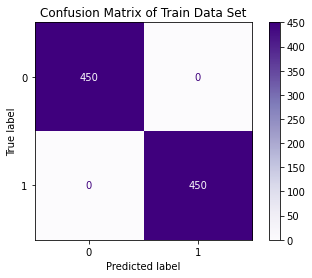

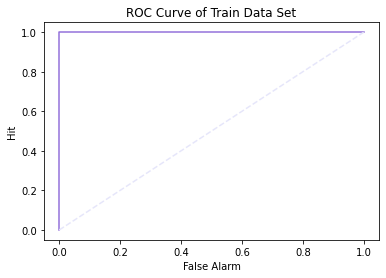

In [ ]:
#Train Stats:
myMetrics.giveMetrics(dataSetType='Train Data Set', accCVState=True, accState=False,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Train Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Train Data Set'})

╒═══════════════╤════════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (without CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪════════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │           93.42            │         0.88          │         0.96          │        0.93        │
╘═══════════════╧════════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


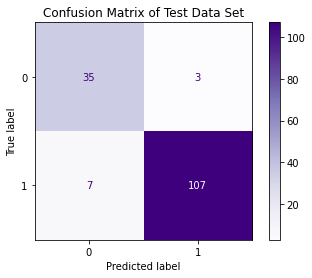

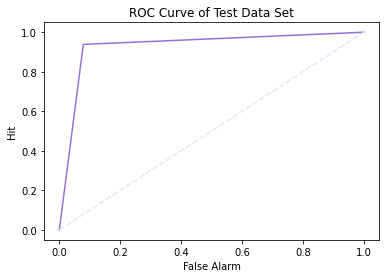

In [ ]:
#Test Stats:
myMetrics.giveMetrics(dataSetType='Test Data Set', accCVState=False, accState=True,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Test Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Test Data Set'})

### <font color=slateblue>**Logistic Regression**</font> ###

In [70]:
myDataPath = '/content/gdrive/My Drive/Colab Notebooks/Final Project/pd_speech_features.csv'

trainData, testData, trainLabels, testLabels = readAndPreProsData(dataPath=myDataPath, 
                                                                  dimReductionMethod='AE', 
                                                                  dimReductionInfo={'Auto Encoder Dimension':50}, 
                                                                  normMethod='Standard Scaler')
#Finding the best values with "Grid Search CV"
grid = {'C':np.logspace(-3, 3, 7), 'penalty':['l1','l2'], 'solver':['saga', 'liblinear']}
myLR = LR(max_iter=10000, random_state=42)
myMetrics = Metrics(myLR, trainData, trainLabels, np.array([]), np.array([]))
bestParam = myMetrics.gridSearchCV(10, grid)

The number of missing data is: 0
After balancing data we got:  {0: 450, 1: 450}
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_520 (InputLayer)       [(None, 753)]             0         
_________________________________________________________________
dense_525 (Dense)            (None, 50)                37700     
_________________________________________________________________
dense_526 (Dense)            (None, 753)               38403     
Total params: 76,103
Trainable params: 76,103
Non-trainable params: 0
_________________________________________________________________
╒════════════════════════╤════════════════════════════════════════════════════╤══════════════╤═══════════════════════╕
│  Parameters to Adjust  │                         C                          │   penalty    │        solver         │
╞════════════════════════╪════════════════════════════════════════

In [71]:
#Employing the best LR for the given data set:
myLR = LR(max_iter=10000, random_state=42, solver=bestParam['solver'], 
          C=bestParam['C'], penalty=bestParam['penalty'])
myLR.fit(trainData, trainLabels)
myMetrics = Metrics(myLR, trainData, trainLabels, testData, testLabels)

╒═══════════════╤═════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (with CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪═════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │       83.56±5.35        │         0.87          │         0.87          │        0.87        │
╘═══════════════╧═════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


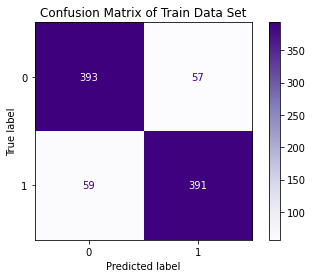

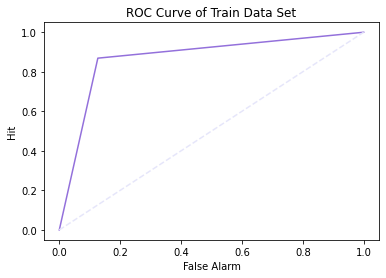

In [72]:
#Train Stats:
myMetrics.giveMetrics(dataSetType='Train Data Set', accCVState=True, accState=False,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Train Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Train Data Set'})

╒═══════════════╤════════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (without CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪════════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │           80.92            │         0.68          │         0.86          │        0.81        │
╘═══════════════╧════════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


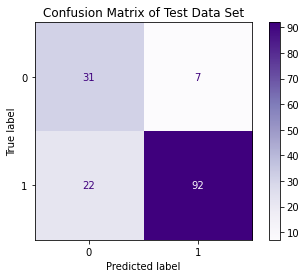

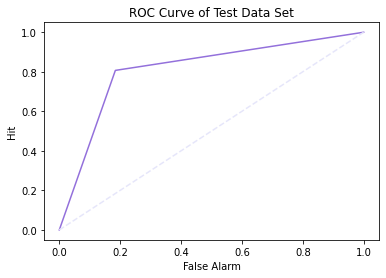

In [73]:
#Test Stats:
myMetrics.giveMetrics(dataSetType='Test Data Set', accCVState=False, accState=True,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Test Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Test Data Set'})

### <font color=slateblue>**Decision Tree**</font> ###

In [82]:
myDataPath = '/content/gdrive/My Drive/Colab Notebooks/Final Project/pd_speech_features.csv'

trainData, testData, trainLabels, testLabels = readAndPreProsData(dataPath=myDataPath, 
                                                                  dimReductionMethod='AE', 
                                                                  dimReductionInfo={'Auto Encoder Dimension':100}, 
                                                                  normMethod='Min Max Scaler')

#Finding the best parameters with "Grid Search CV"
grid = {'criterion': ['gini', 'entropy'], 'max_depth': [4 ,8, 12, 15, 16, 20, 24, 28], 
        'min_samples_split': [2, 3, 4, 5], 'max_features':['auto', 'sqrt', 'log2']}
myDT = DT(random_state=42)
myMetrics = Metrics(myDT, trainData, trainLabels, np.array([]), np.array([]))
bestParam = myMetrics.gridSearchCV(10, grid)

The number of missing data is: 0
After balancing data we got:  {0: 450, 1: 450}
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_523 (InputLayer)       [(None, 753)]             0         
_________________________________________________________________
dense_531 (Dense)            (None, 100)               75400     
_________________________________________________________________
dense_532 (Dense)            (None, 753)               76053     
Total params: 151,453
Trainable params: 151,453
Non-trainable params: 0
_________________________________________________________________
╒════════════════════════╤═════════════════════╤════════════════════════════════╤═════════════════════╤══════════════════════════╕
│  Parameters to Adjust  │      criterion      │           max_depth            │  min_samples_split  │       max_features       │
╞════════════════════════╪══════════════

In [84]:
#Employing the best DT for the given data set:
myDT = DT(criterion=bestParam['criterion'], random_state=42, 
          max_depth=bestParam['max_depth'], 
          min_samples_split=bestParam['min_samples_split'],
          max_features=bestParam['max_features'])
myDT.fit(trainData, trainLabels)
myMetrics = Metrics(myDT, trainData, trainLabels, testData, testLabels)

╒═══════════════╤═════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (with CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪═════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │       84.44±2.90        │           1           │           1           │         1          │
╘═══════════════╧═════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


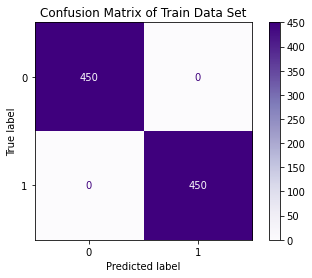

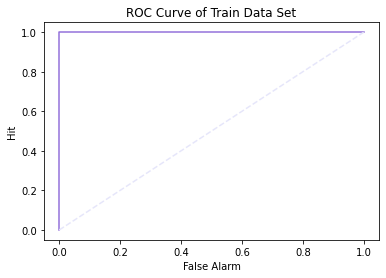

In [85]:
#Train Stats:
myMetrics.giveMetrics(dataSetType='Train Data Set', accCVState=True, accState=False,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Train Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Train Data Set'})

╒═══════════════╤════════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (without CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪════════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │           76.32            │         0.56          │         0.84          │        0.71        │
╘═══════════════╧════════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


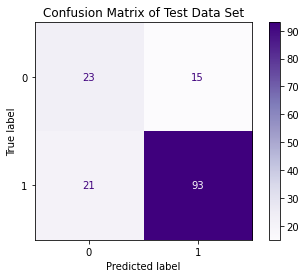

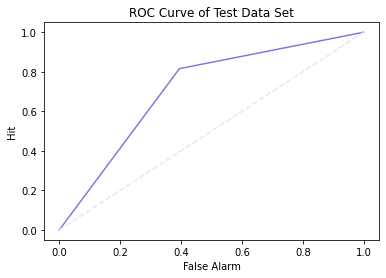

In [86]:
#Test Stats:
myMetrics.giveMetrics(dataSetType='Test Data Set', accCVState=False, accState=True,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Test Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Test Data Set'})

### <font color=slateblue>**Support Vector Machines**</font> ###

In [10]:
trainData, testData, trainLabels, testLabels = readAndPreProsData(dataPath=myDataPath, 
                                                                  dimReductionMethod='AE', 
                                                                  dimReductionInfo={'Auto Encoder Dimension':50}, 
                                                                  normMethod='Standard Scaler')
#Finding the best parameters with "Grid Search CV"
grid = {'kernel': ['rbf', 'linear'], 
        'gamma': [ 1e-3, 2*(1e-3), 3*(1e-3), 4*(1e-3)],
        'C': np.arange(1, 200, 100).tolist()}
mySVM = SVC(random_state=42)
myMetrics = Metrics(mySVM, trainData, trainLabels, np.array([]), np.array([]))
bestParam = myMetrics.gridSearchCV(10, grid)

The number of missing data is: 0
After balancing data we got:  {0: 450, 1: 450}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 753)]             0         
_________________________________________________________________
dense (Dense)                (None, 50)                37700     
_________________________________________________________________
dense_1 (Dense)              (None, 753)               38403     
Total params: 76,103
Trainable params: 76,103
Non-trainable params: 0
_________________________________________________________________
╒════════════════════════╤═══════════════════╤══════════════════════════════╤══════════╕
│  Parameters to Adjust  │      kernel       │            gamma             │    C     │
╞════════════════════════╪═══════════════════╪══════════════════════════════╪══════════╡
│    Hyperparameters     │ ['rbf', 'line

In [11]:
#Employing the best SVM for the given data set:
mySVM = SVC(kernel= bestParam['kernel'], 
            gamma = bestParam['gamma'], 
            C = bestParam['C'])
mySVM.fit(trainData, trainLabels)
myMetrics = Metrics(mySVM, trainData, trainLabels, testData, testLabels)

╒═══════════════╤═════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (with CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪═════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │       95.89±2.44        │           1           │           1           │         1          │
╘═══════════════╧═════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


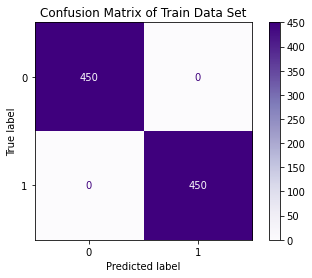

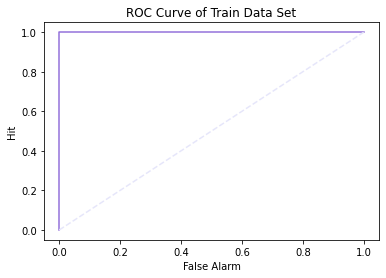

In [12]:
#Train Stats:
myMetrics.giveMetrics(dataSetType='Train Data Set', accCVState=True, accState=False,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Train Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Train Data Set'})

╒═══════════════╤════════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (without CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪════════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │           89.47            │         0.76          │         0.93          │        0.82        │
╘═══════════════╧════════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


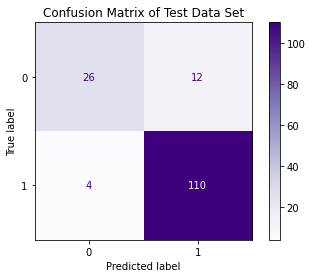

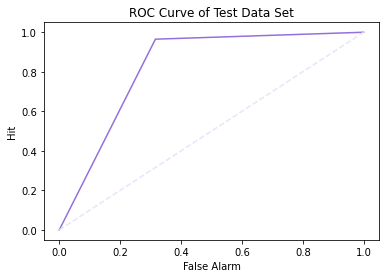

In [13]:
#Test Stats:
myMetrics.giveMetrics(dataSetType='Test Data Set', accCVState=False, accState=True,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Test Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Test Data Set'})

### <font color=slateblue>**Radial Basis Function**</font> ###

In [87]:
class RBFLayer(Layer):
  def __init__(self, units, gamma, **kwargs):
    super(RBFLayer, self).__init__(**kwargs)
    self.units = units
    self.gamma = K.cast_to_floatx(gamma)

  def build(self, input_shape):
    self.mu = self.add_weight(name='mu',
                              shape=(int(input_shape[1]), self.units),
                              initializer='uniform',
                              trainable=True)
    super(RBFLayer, self).build(input_shape)

  def call(self, inputs):
    diff = K.expand_dims(inputs) - self.mu
    l2 = K.sum(K.pow(diff,2), axis=1)
    res = K.exp(-1 * self.gamma * l2)
    return res

  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.units)

In [88]:
class RBFClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self,nodes = 20, gamma = 0.1, dim = 754):
    self.nodes = nodes
    self.gamma = gamma

  def getModel(self):
    myModel = Sequential()
    my_input =layers.Input(shape=(np.shape(trainData)[1],))
    myModel.add(my_input)
    myModel.add( RBFLayer(self.nodes, self.gamma))
    myModel.add(Dense(2, activation='softmax'))
    sgd = SGD(lr=0.06, decay=1e-6, momentum=0.5, nesterov=False)
    myModel.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return myModel

  def fit(self, trainData, trainLabels):
    trainLabels = np_utils.to_categorical(trainLabels)
    classNumbers = len(np.unique(trainLabels))
    self.models_ = KerasClassifier(build_fn=self.getModel, verbose=0)
    self.models_.fit(trainData, trainLabels,  batch_size=32 , epochs=100 , validation_split=0.2)
    return self

  def predict(self, data):
    prediction = self.models_.predict(data)
    return prediction

In [89]:
trainData, testData, trainLabels, testLabels = readAndPreProsData(dataPath=myDataPath, 
                                                                  dimReductionMethod='AE', 
                                                                  dimReductionInfo={'Auto Encoder Dimension':75}, 
                                                                  normMethod='Min Max Scaler')

#Finding the best bandwidth with "Grid Search CV"
grid = {'nodes': [10,25,50], 'gamma':[0.01,0.1,0.4]}
myMetrics = Metrics(RBFClassifier(dim = np.shape(trainData)[1]), trainData, trainLabels, np.array([]), np.array([]))
bestParam = myMetrics.gridSearchCV(10, grid)

The number of missing data is: 0
After balancing data we got:  {0: 450, 1: 450}
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_524 (InputLayer)       [(None, 753)]             0         
_________________________________________________________________
dense_533 (Dense)            (None, 75)                56550     
_________________________________________________________________
dense_534 (Dense)            (None, 753)               57228     
Total params: 113,778
Trainable params: 113,778
Non-trainable params: 0
_________________________________________________________________
╒════════════════════════╤══════════════╤══════════════════╕
│  Parameters to Adjust  │    nodes     │      gamma       │
╞════════════════════════╪══════════════╪══════════════════╡
│    Hyperparameters     │ [10, 25, 50] │ [0.01, 0.1, 0.4] │
╘════════════════════════╧══════════════╧═════════════════

In [90]:
myRBF = RBFClassifier(dim = np.shape(trainData)[1], nodes=bestParam['nodes'], gamma=bestParam['gamma'])
myRBF.fit(trainData, trainLabels)
myMetrics = Metrics(myRBF, trainData, trainLabels, testData, testLabels)

╒═══════════════╤═════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (with CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪═════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │       73.11±4.38        │          0.7          │         0.79          │        0.75        │
╘═══════════════╧═════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


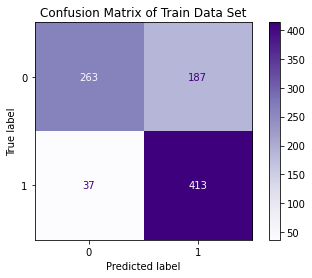

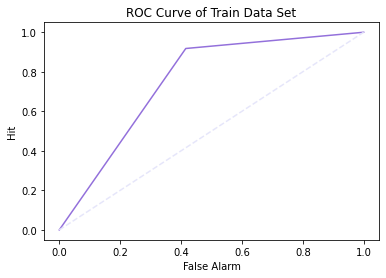

In [91]:
#Train Stats:
myMetrics.giveMetrics(dataSetType='Train Data Set', accCVState=True, accState=False,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Train Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Train Data Set'})

╒═══════════════╤════════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (without CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪════════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │           81.58            │          0.6          │         0.88          │        0.73        │
╘═══════════════╧════════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


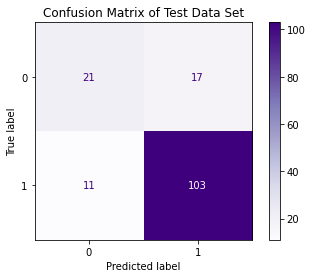

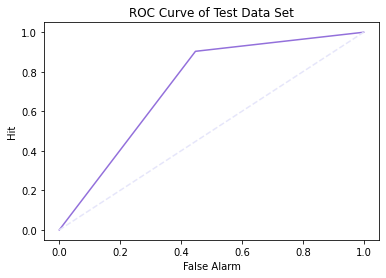

In [92]:
#Test Stats:
myMetrics.giveMetrics(dataSetType='Test Data Set', accCVState=False, accState=True,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Test Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Test Data Set'})

### <font color=slateblue>**Multi Layer Perceptron**</font> ###

In [ ]:
myDataPath = '/content/gdrive/My Drive/Colab Notebooks/Final Project/pd_speech_features.csv'

trainData, testData, trainLabels, testLabels = readAndPreProsData(dataPath=myDataPath, 
                                                                  dimReductionMethod='ICA', 
                                                                  dimReductionInfo={'Number of Components':40, 
                                                                                    'Whitening State':True,
                                                                                    'Max Iteration':200}, 
                                                                  normMethod='Min Max Scaler')
#Finding the best parameters with "Grid Search CV"
myMLP = MLPClassifier(hidden_layer_sizes=(900,700), verbose=False, 
                      random_state=42, max_iter=300, solver='adam', 
                      learning_rate='invscaling', 
                      activation='relu').fit(trainData, trainLabels)                     

The number of missing data is: 0
After balancing data we got:  {0: 450, 1: 450}


In [ ]:
#Employing the best MLP for the given data set:
myMetrics = Metrics(myMLP, trainData, trainLabels, testData, testLabels)

╒═══════════════╤═════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (with CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪═════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │       95.67±2.92        │           1           │           1           │         1          │
╘═══════════════╧═════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


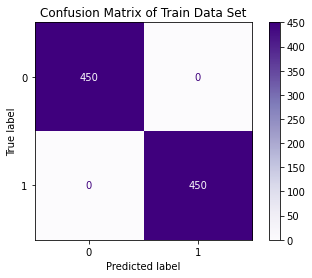

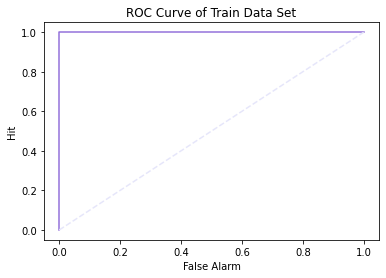

In [ ]:
#Train Stats:
myMetrics.giveMetrics(dataSetType='Train Data Set', accCVState=True, accState=False,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Train Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Train Data Set'})

╒═══════════════╤════════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (without CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪════════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │           91.45            │         0.82          │         0.94          │        0.87        │
╘═══════════════╧════════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


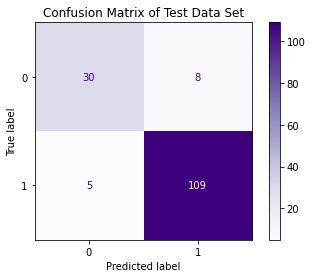

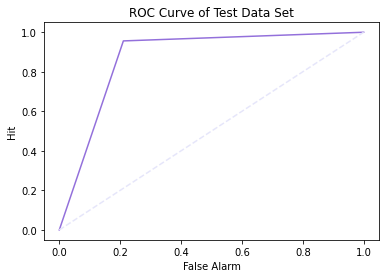

In [ ]:
#Test Stats:
myMetrics.giveMetrics(dataSetType='Test Data Set', accCVState=False, accState=True,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Test Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Test Data Set'})

# <font color=slateblue>**Generative Approach**</font> #

### <font color=MediumSlateBlue>**Parzen Window and Bayesian Decision Making**</font> ###

In [11]:
class ParzenAndBayes(BaseEstimator, ClassifierMixin):
  def __init__(self, bandwidth=1.0, kernel='gaussian'):
    self.bandwidth = bandwidth
    self.kernel = kernel
      
  def fit(self, data, dataLabels):
    self.classes_ = np.sort(np.unique(dataLabels))
    trainingSets = [data[dataLabels == dataLabel] for dataLabel in self.classes_]
    self.models_ = [KernelDensity(bandwidth=self.bandwidth, 
                                  kernel=self.kernel).fit(sample) for sample in trainingSets]
    self.logpriors_ = [np.log(sample.shape[0] / data.shape[0]) for sample in trainingSets]

    return self
      
  def predict_proba(self, data):
    logprobs = np.array([model.score_samples(data) for model in self.models_]).T
    result = np.exp(logprobs + self.logpriors_)
    return result / result.sum(0, keepdims=True)
      
  def predict(self, data):
    return self.classes_[np.argmax(self.predict_proba(data), 1)]

In [35]:
myDataPath = '/content/gdrive/My Drive/Colab Notebooks/Final Project/pd_speech_features.csv'


trainData, testData, trainLabels, testLabels = readAndPreProsData(dataPath=myDataPath, 
                                                                  dimReductionMethod='AE', 
                                                                  dimReductionInfo={'Auto Encoder Dimension':100}, 
                                                                  normMethod='Standard Scaler')

#Finding the best bandwidth with "Grid Search CV"
grid = {'bandwidth': 10 ** np.linspace(0, 1, 20), 
        'kernel': ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']}
myMetrics = Metrics(ParzenAndBayes(), trainData, trainLabels, np.array([]), np.array([]))
bestParam = myMetrics.gridSearchCV(10, grid)

The number of missing data is: 0
After balancing data we got:  {0: 450, 1: 450}
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 753)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               75400     
_________________________________________________________________
dense_3 (Dense)              (None, 753)               76053     
Total params: 151,453
Trainable params: 151,453
Non-trainable params: 0
_________________________________________________________________
╒════════════════════════╤══════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════════════════════╕
│  Parameters to Adjust  │                                bandwidth                                 │                        

In [36]:
#Employing the best Parzen Window for the given data set:
myParAndBayes = ParzenAndBayes(bandwidth=bestParam['bandwidth'], kernel=bestParam['kernel'])
myParAndBayes.fit(trainData, trainLabels)
myMetrics = Metrics(myParAndBayes, trainData, trainLabels, testData, testLabels)

╒═══════════════╤═════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (with CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪═════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │       95.89±3.55        │           1           │           1           │         1          │
╘═══════════════╧═════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


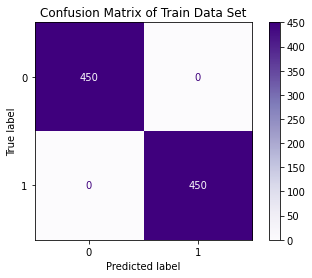

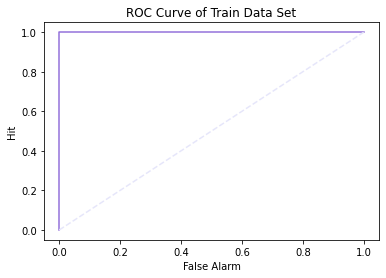

In [39]:
#Train Stats:
myMetrics.giveMetrics(dataSetType='Train Data Set', accCVState=True, accState=False,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Train Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Train Data Set'})

╒═══════════════╤════════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (without CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪════════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │           89.47            │         0.81          │         0.93          │        0.89        │
╘═══════════════╧════════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


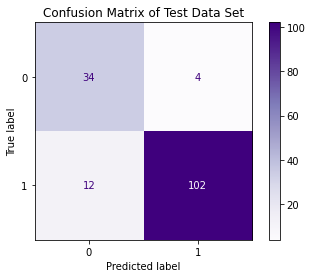

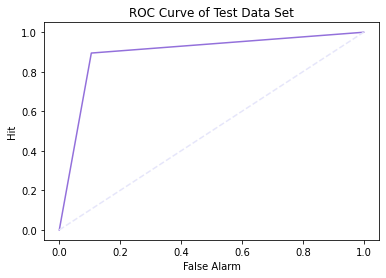

In [38]:
#Test Stats:
myMetrics.giveMetrics(dataSetType='Test Data Set', accCVState=False, accState=True,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Test Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Test Data Set'})

### <font color=MediumSlateBlue>**K-Nearest Neighbors and Bayesian Decision Making**</font> ###

In [48]:
class KNNandBayes(BaseEstimator, ClassifierMixin):
  def __init__(self, weights='distance', n_neighbors=1, p=1):
    self.weights = weights
    self.n_neighbors = n_neighbors
    self.p = p
      
  def fit(self, data, dataLabels):
    self.classes_ = np.sort(np.unique(dataLabels))
    self.model_ = KNN(weights=self.weights, n_neighbors=self.n_neighbors, p=self.p).fit(data, dataLabels)
    return self
      
  def predict_proba(self, data):
    return self.model_.predict_proba(data)
      
  def predict(self, data):
    return self.classes_[np.argmax(self.predict_proba(data),1)]

In [49]:
myDataPath = '/content/gdrive/My Drive/Colab Notebooks/Final Project/pd_speech_features.csv'


trainData, testData, trainLabels, testLabels = readAndPreProsData(dataPath=myDataPath, 
                                                                  dimReductionMethod='ICA', 
                                                                  dimReductionInfo={'Number of Components':40, 
                                                                                    'Whitening State':True,
                                                                                    'Max Iteration':200}, 
                                                                  normMethod='Min Max Scaler')

#Finding the best parameters with "Grid Search CV"
grid = {'n_neighbors':[1, 4, 6, 8, 10, 12], 'p':[1, 2, 3]}
myMetrics = Metrics(KNNandBayes(), trainData, trainLabels, np.array([]), np.array([]))
bestParam = myMetrics.gridSearchCV(10, grid)

The number of missing data is: 0
After balancing data we got:  {0: 450, 1: 450}
╒════════════════════════╤══════════════════════╤═══════════╕
│  Parameters to Adjust  │     n_neighbors      │     p     │
╞════════════════════════╪══════════════════════╪═══════════╡
│    Hyperparameters     │ [1, 4, 6, 8, 10, 12] │ [1, 2, 3] │
╘════════════════════════╧══════════════════════╧═══════════╛
╒════════════════════════╤═══════════════╤═════╕
│  Parameters to Adjust  │  n_neighbors  │  p  │
╞════════════════════════╪═══════════════╪═════╡
│    Hyperparameters     │       1       │  2  │
╘════════════════════════╧═══════════════╧═════╛


In [51]:
#Employing the best DT for the given data set:
myKNNandBayes = KNNandBayes(weights='distance', n_neighbors=bestParam['n_neighbors'], p=bestParam['p'])
myKNNandBayes.fit(trainData, trainLabels)
myMetrics = Metrics(myKNNandBayes, trainData, trainLabels, testData, testLabels)

╒═══════════════╤═════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (with CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪═════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │       95.67±2.79        │           1           │           1           │         1          │
╘═══════════════╧═════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


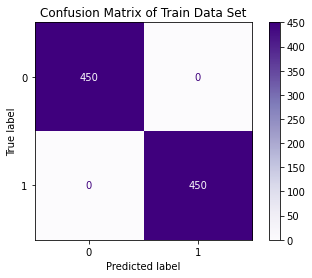

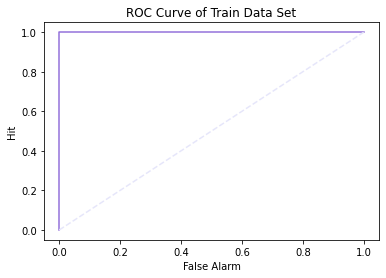

In [52]:
#Train Stats:
myMetrics.giveMetrics(dataSetType='Train Data Set', accCVState=True, accState=False,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Train Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Train Data Set'})

╒═══════════════╤════════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (without CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪════════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │           93.42            │         0.88          │         0.96          │        0.93        │
╘═══════════════╧════════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


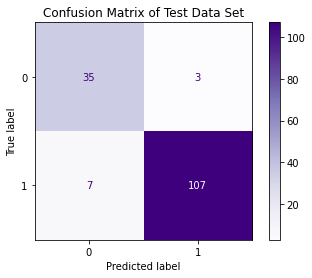

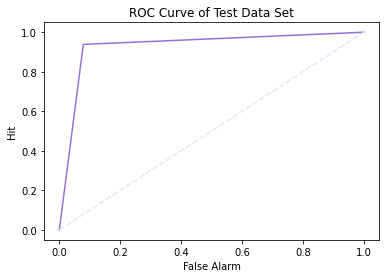

In [53]:
#Test Stats:
myMetrics.giveMetrics(dataSetType='Test Data Set', accCVState=False, accState=True,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Test Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Test Data Set'})

### <font color=MediumSlateBlue>**Gaussian Mixture Models and Bayesian Decision Making**</font> ###

In [67]:
class GMMAndBayes(BaseEstimator, ClassifierMixin):
  def __init__(self, covtype='diag'):
    self.covtype = covtype
      
  def fit(self, data, dataLabels):
    n_classes = len(np.unique(dataLabels))
    self.classes_ = np.sort(np.unique(dataLabels))
    training_sets = [data[dataLabels == dataLabel] for dataLabel in self.classes_]
    GMM_means =  np.array([data[dataLabels == i].mean(axis=0)
                                for i in xrange(n_classes)])
    self.models_ =  [GMM(n_components=len(np.unique(dataLabels)), 
                         covariance_type =self.covtype, tol=0.001, 
                         random_state = 42, means_init = GMM_means, 
                         reg_covar=0.01, max_iter=10000).fit(sample)
                                  for sample in training_sets]
    self.logpriors_ = [np.log(sample.shape[0] / data.shape[0])
                        for sample in training_sets]
    return self
      
  def predict_proba(self, data):
    logprobs = np.array([model.score_samples(data)
                          for model in self.models_]).T
    result = np.exp(logprobs + self.logpriors_)
    return result / result.sum(1, keepdims=True)
      
  def predict(self, data):
    return self.classes_[np.argmax(self.predict_proba(data), 1)]

In [68]:
trainData, testData, trainLabels, testLabels = readAndPreProsData(dataPath=myDataPath, 
                                                                  dimReductionMethod='AE', 
                                                                  dimReductionInfo={'Auto Encoder Dimension':92}, 
                                                                  normMethod='Standard Scaler')
#Finding the best bandwidth with "Grid Search CV"
grid = {'covtype': ['spherical', 'diag', 'tied', 'full']}
myMetrics = Metrics(GMMAndBayes(), trainData, trainLabels, np.array([]), np.array([]))
bestParam = myMetrics.gridSearchCV(10, grid)

The number of missing data is: 0
After balancing data we got:  {0: 450, 1: 450}
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 753)]             0         
_________________________________________________________________
dense_10 (Dense)             (None, 92)                69368     
_________________________________________________________________
dense_11 (Dense)             (None, 753)               70029     
Total params: 139,397
Trainable params: 139,397
Non-trainable params: 0
_________________________________________________________________
╒════════════════════════╤═══════════════════════════════════════╕
│  Parameters to Adjust  │                covtype                │
╞════════════════════════╪═══════════════════════════════════════╡
│    Hyperparameters     │ ['spherical', 'diag', 'tied', 'full'] │
╘════════════════════════╧═════════

In [69]:
#Employing the best GMM for the given data set:
myGMM = GMMAndBayes(covtype= bestParam['covtype'])
myGMM.fit(trainData, trainLabels)
myMetrics = Metrics(myGMM, trainData, trainLabels, testData, testLabels)

╒═══════════════╤═════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (with CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪═════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │       92.44±5.68        │         0.99          │         0.99          │        0.99        │
╘═══════════════╧═════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


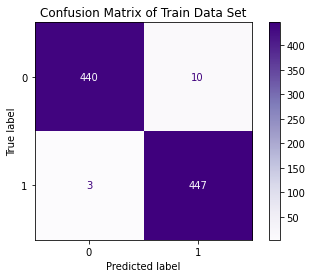

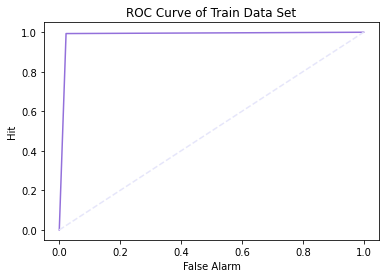

In [70]:
#Train Stats:
myMetrics.giveMetrics(dataSetType='Train Data Set', accCVState=True, accState=False,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Train Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Train Data Set'})

╒═══════════════╤════════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (without CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪════════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │           82.89            │         0.57          │         0.89          │        0.7         │
╘═══════════════╧════════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


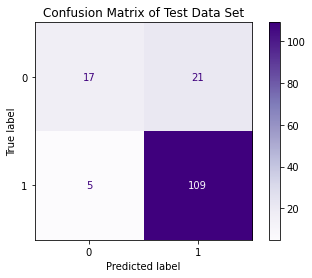

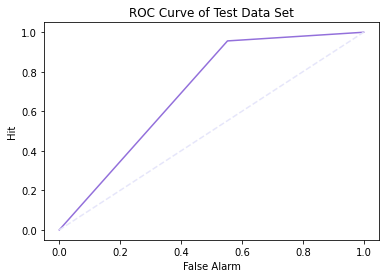

In [71]:
#Test Stats:
myMetrics.giveMetrics(dataSetType='Test Data Set', accCVState=False, accState=True,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Test Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Test Data Set'})

# <font color=slateblue>**Ensemble Learning**</font> #

### <font color=MediumSlateBlue>**Base Estimator: SVM**</font> ###

In [51]:
gamma_set =  [ 1e-3, 2*(1e-3), 3*(1e-2), 4*(1e-1)]
C_set = [10,100,200,400,500]
clfs = []
for gam in gamma_set:
  for c in C_set:
    clfs.append(SVC(kernel = 'rbf', gamma = gam, C = c))
grid = {'base_estimator':clfs}

In [55]:
trainData, testData, trainLabels, testLabels = readAndPreProsData(dataPath=myDataPath, 
                                                                  dimReductionMethod='AE', 
                                                                  dimReductionInfo={'Auto Encoder Dimension':100}, 
                                                                  normMethod='Standard Scaler')
myBagg = BaggingClassifier(n_estimators=20, random_state=42)
myMetrics = Metrics(myBagg, trainData, trainLabels, np.array([]), np.array([]))
bestParam = myMetrics.gridSearchCV(10, grid)

The number of missing data is: 0
After balancing data we got:  {0: 450, 1: 450}
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_517 (InputLayer)       [(None, 753)]             0         
_________________________________________________________________
dense_519 (Dense)            (None, 100)               75400     
_________________________________________________________________
dense_520 (Dense)            (None, 753)               76053     
Total params: 151,453
Trainable params: 151,453
Non-trainable params: 0
_________________________________________________________________
╒════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│  Parameters to Adjust  │                                              base_estimator                                               │
╞════════════════════════╪═══════

In [56]:
#Employing the best SVM for the given data set:
myBagg = BaggingClassifier(base_estimator=bestParam['base_estimator'], n_estimators=10, random_state=0)
myBagg.fit(trainData, trainLabels)
myMetrics = Metrics(myBagg, trainData, trainLabels, testData, testLabels)

╒═══════════════╤═════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (with CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪═════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │       94.78±3.41        │         0.99          │         0.99          │        0.99        │
╘═══════════════╧═════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


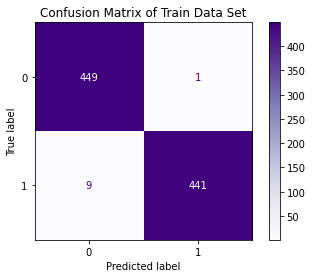

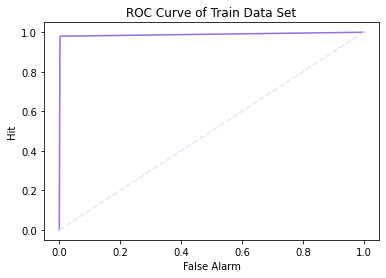

In [58]:
#Train Stats:
myMetrics.giveMetrics(dataSetType='Train Data Set', accCVState=True, accState=False,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Train Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Train Data Set'})

╒═══════════════╤════════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (without CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪════════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │           84.87            │          0.7          │          0.9          │        0.8         │
╘═══════════════╧════════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


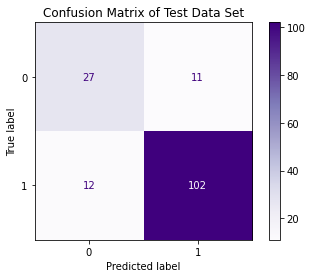

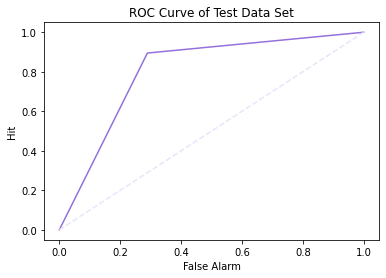

In [59]:
#Test Stats:
myMetrics.giveMetrics(dataSetType='Test Data Set', accCVState=False, accState=True,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Test Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Test Data Set'})

### <font color=MediumSlateBlue>**Base Estimator: DT**</font> ###

In [60]:
criterion_set =   ['gini', 'entropy']
max_depth_set =  [10, 12, 16, 20, 24]
samples_spli_set = [2, 3, 4]
clfs = []
for crit in criterion_set:
  for depth in max_depth_set:
    for s_split in samples_spli_set:
        clfs.append(DT(criterion = crit, max_depth = depth, min_samples_split = s_split))
grid = {'base_estimator':clfs}

In [61]:
trainData, testData, trainLabels, testLabels = readAndPreProsData(dataPath=myDataPath, 
                                                                  dimReductionMethod='AE', 
                                                                  dimReductionInfo={'Auto Encoder Dimension':75}, 
                                                                  normMethod='Min Max Scaler')
#Finding the best parameters with "Grid Search CV"
myBagg = BaggingClassifier(n_estimators=20, random_state=42)
myMetrics = Metrics(myBagg, trainData, trainLabels, np.array([]), np.array([]))
bestParam = myMetrics.gridSearchCV(10, grid)

The number of missing data is: 0
After balancing data we got:  {0: 450, 1: 450}
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_518 (InputLayer)       [(None, 753)]             0         
_________________________________________________________________
dense_521 (Dense)            (None, 75)                56550     
_________________________________________________________________
dense_522 (Dense)            (None, 753)               57228     
Total params: 113,778
Trainable params: 113,778
Non-trainable params: 0
_________________________________________________________________
╒════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│  Parameters to Adjust  │                                                              base_estimator                                  

In [62]:
#Employing the best Bag-DT for the given data set:
myBagg = BaggingClassifier(base_estimator=bestParam['base_estimator'], n_estimators=10, random_state=0)
myBagg.fit(trainData, trainLabels)
myMetrics = Metrics(myBagg, trainData, trainLabels, testData, testLabels)

╒═══════════════╤═════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (with CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪═════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │       90.78±1.49        │           1           │           1           │         1          │
╘═══════════════╧═════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


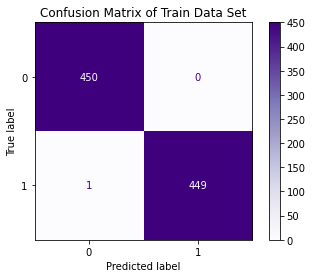

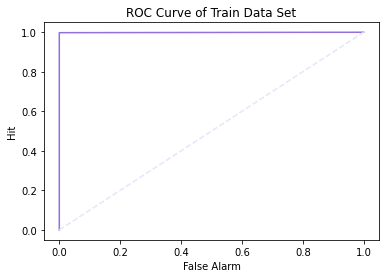

In [63]:
#Train Stats:
myMetrics.giveMetrics(dataSetType='Train Data Set', accCVState=True, accState=False,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Train Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Train Data Set'})

╒═══════════════╤════════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (without CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪════════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │           78.29            │         0.56          │         0.86          │        0.71        │
╘═══════════════╧════════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


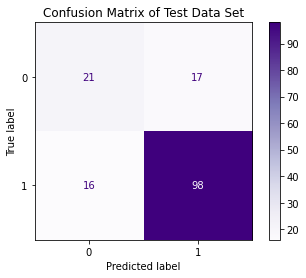

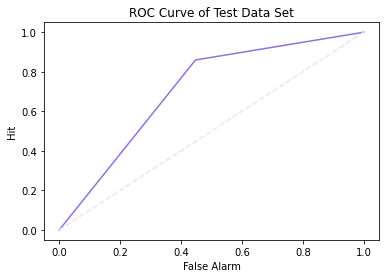

In [64]:
#Test Stats:
myMetrics.giveMetrics(dataSetType='Test Data Set', accCVState=False, accState=True,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Test Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Test Data Set'})

### <font color=MediumSlateBlue>**Base Estimator: KNN**</font> ###

In [65]:
n_neighbors_set =   [1, 4, 6, 8, 10, 12]
weights_set =  ['uniform','distance']
p_set = [1, 2]
clfs = []
for neigh in n_neighbors_set:
  for weight in weights_set:
    for _p in p_set:
        clfs.append(KNN(n_neighbors = neigh, weights = weight, p = _p))
grid = {'base_estimator':clfs}

In [66]:
trainData, testData, trainLabels, testLabels = readAndPreProsData(dataPath=myDataPath, 
                                                                  dimReductionMethod='AE', 
                                                                  dimReductionInfo={'Auto Encoder Dimension':100}, 
                                                                  normMethod='Min Max Scaler')
#Finding the best parameters with "Grid Search CV"
myBagg = BaggingClassifier(n_estimators=10, random_state=42)
myMetrics = Metrics(myBagg, trainData, trainLabels, np.array([]), np.array([]))
bestParam = myMetrics.gridSearchCV(10, grid)

The number of missing data is: 0
After balancing data we got:  {0: 450, 1: 450}
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_519 (InputLayer)       [(None, 753)]             0         
_________________________________________________________________
dense_523 (Dense)            (None, 100)               75400     
_________________________________________________________________
dense_524 (Dense)            (None, 753)               76053     
Total params: 151,453
Trainable params: 151,453
Non-trainable params: 0
_________________________________________________________________
╒════════════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│  Parameters to Adjust  │                                                   base_estimator                                                   │
╞══════════════

In [67]:
#Employing the best SVM for the given data set:
myBagg = BaggingClassifier(base_estimator=bestParam['base_estimator'], n_estimators=10, random_state=0)
myBagg.fit(trainData, trainLabels)
myMetrics = Metrics(myBagg, trainData, trainLabels, testData, testLabels)

╒═══════════════╤═════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (with CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪═════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │       95.11±2.23        │         0.99          │         0.99          │        0.99        │
╘═══════════════╧═════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


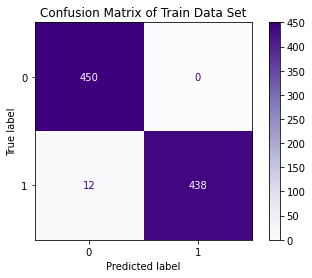

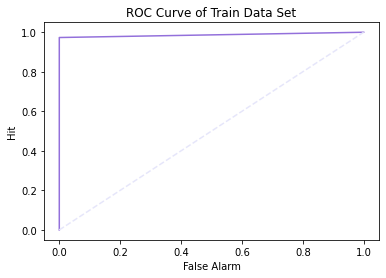

In [68]:
#Train Stats:
myMetrics.giveMetrics(dataSetType='Train Data Set', accCVState=True, accState=False,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Train Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Train Data Set'})

╒═══════════════╤════════════════════════════╤═══════════════════════╤═══════════════════════╤════════════════════╕
│  Metric Type  │  Accuracy (without CV)(%)  │  f1 Score of Class 0  │  f1 Score of Class 1  │  Area Under Curve  │
╞═══════════════╪════════════════════════════╪═══════════════════════╪═══════════════════════╪════════════════════╡
│    Values     │           88.82            │          0.8          │         0.92          │        0.89        │
╘═══════════════╧════════════════════════════╧═══════════════════════╧═══════════════════════╧════════════════════╛


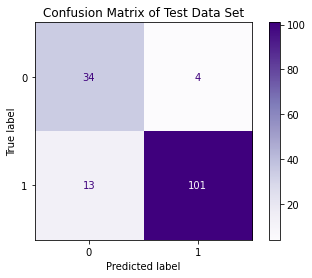

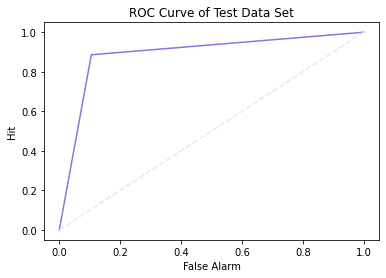

In [69]:
#Test Stats:
myMetrics.giveMetrics(dataSetType='Test Data Set', accCVState=False, accState=True,
                      f1ScoreState=True, AUCState=True, 
                      confMatrixState=True, 
                      confMatrixInfo={'Displayed Labels':[0,1], 
                                      'Matrix Title':'Confusion Matrix of Test Data Set'}, 
                      ROCCurveState=True, ROCCurveInfo={'Plot Title':'ROC Curve of Test Data Set'})

## <font color=MediumSlateBlue>**One Last Note**</font> ##

Below code is for backward feature selection which did not perform well in any part of our project. Therefore, we did not include it in our preprocessing class.

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
_myKNN = KNN(n_neighbors=1)
sbs = SFS(_myKNN, k_features=245, forward=False, floating=False, scoring='accuracy', cv=4, n_jobs=-1)
sbs = sbs.fit(trainData, trainLabels)
